In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

Load The Dataset

In [4]:
data = pd.read_csv('/content/drive/MyDrive/DataSet 2/WSN-DS.csv')

Code for Splitting Data

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Step 1: Split the dataset into 2 equal parts
part1, temp_part = train_test_split(
    data,
    test_size=0.5,
    stratify=data['Attack type']
)

# Step 2: Split the temporary part into 2 equal parts again
part2, part3 = train_test_split(
    temp_part,
   test_size=0.5,
    stratify=temp_part['Attack type']
)

# Step 3: Split one of the resulting parts into 2 equal parts again
part3, part4 = train_test_split(
    part3,
    test_size=0.5,
    stratify=part3['Attack type']
)

# Verify the distribution
print("Part 1 class distribution:\n", part1['Attack type'].value_counts())
print("Part 2 class distribution:\n", part2['Attack type'].value_counts())
print("Part 3 class distribution:\n", part3['Attack type'].value_counts())
print("Part 4 class distribution:\n", part4['Attack type'].value_counts())

Part 1 class distribution:
 Attack type
Normal       170033
Grayhole       7298
Blackhole      5024
TDMA           3319
Flooding       1656
Name: count, dtype: int64
Part 2 class distribution:
 Attack type
Normal       85016
Grayhole      3649
Blackhole     2512
TDMA          1660
Flooding       828
Name: count, dtype: int64
Part 3 class distribution:
 Attack type
Normal       42508
Grayhole      1824
Blackhole     1257
TDMA           830
Flooding       414
Name: count, dtype: int64
Part 4 class distribution:
 Attack type
Normal       42509
Grayhole      1825
Blackhole     1256
TDMA           829
Flooding       414
Name: count, dtype: int64


In [6]:
data.head()

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Attack type
0,101000,50,1,101000,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,Normal
1,101001,50,0,101044,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,Normal
2,101002,50,0,101010,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,Normal
3,101003,50,0,101044,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,Normal
4,101004,50,0,101010,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,Normal


2.Explore the dataset structure

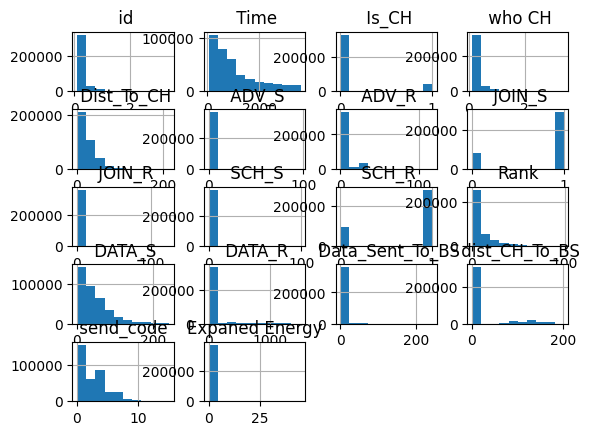

                        id      Time     Is_CH    who CH   Dist_To_CH  \
 id               1.000000  0.674170  0.179659  1.000000    -0.329638   
 Time             0.674170  1.000000  0.282040  0.674184    -0.352468   
 Is_CH            0.179659  0.282040  1.000000  0.179665    -0.372439   
 who CH           1.000000  0.674184  0.179665  1.000000    -0.329650   
 Dist_To_CH      -0.329638 -0.352468 -0.372439 -0.329650     1.000000   
 ADV_S            0.042635  0.012819  0.358947  0.042634    -0.133686   
 ADV_R           -0.039515  0.061591  0.399472 -0.039512    -0.009616   
 JOIN_S          -0.561031 -0.502793 -0.681119 -0.561048     0.546805   
 JOIN_R          -0.046773 -0.039882  0.434253 -0.046774    -0.161619   
 SCH_S           -0.023138  0.000210  0.289925 -0.023138    -0.107979   
 SCH_R           -0.510604 -0.439315 -0.601437 -0.510622     0.458355   
Rank             -0.239057 -0.316458 -0.238737 -0.239066     0.382459   
 DATA_S          -0.183151 -0.042900 -0.381239 -0.1

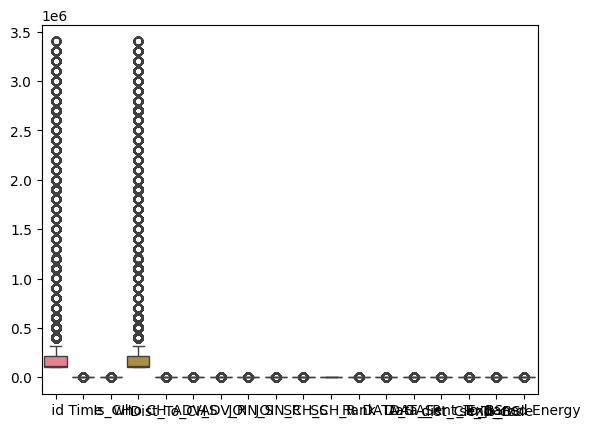

In [7]:
# Explore the first few rows
data.head()

# Check the data types of each column
data.dtypes

# Get descriptive statistics of numerical columns
data.describe()

# Check for missing values
data.isnull().sum()

# Visualize the distribution of numerical columns
data.hist()
plt.show()
# Select numerical columns
numerical_data = data.select_dtypes(include=['int64', 'float64'])

# Calculate correlations using Pearson correlation coefficient
correlations = numerical_data.corr()

# Display the correlations
print(correlations)

# Identify potential outliers using boxplots
import seaborn as sns
sns.boxplot(data=data)
plt.show()

1.3-Preprocess the data by handling missing values, outliers, or inconsistencies to ensure quality data for analysis.

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Handle Missing Values
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

# Handle missing values
if missing_values.any():
    # Option 1: Drop rows with missing values
    data.dropna(inplace=True)

    # Option 2: Impute missing values (example for a specific column)
    # data['missing_column'].fillna(data['missing_column'].mean(), inplace=True)

# Verify no missing values remain
print(data.isnull().sum())

# Step 2: Handle Outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
# Apply outlier removal to all numeric columns
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    data = remove_outliers(data, column)

# Verify the shape of the dataframe after removing outliers
print(data.shape)

# Verify data quality
print(data.describe())
print(data.info())

 id                 0
 Time               0
 Is_CH              0
 who CH             0
 Dist_To_CH         0
 ADV_S              0
 ADV_R              0
 JOIN_S             0
 JOIN_R             0
 SCH_S              0
 SCH_R              0
Rank                0
 DATA_S             0
 DATA_R             0
 Data_Sent_To_BS    0
 dist_CH_To_BS      0
 send_code          0
Expaned Energy      0
Attack type         0
dtype: int64
 id                 0
 Time               0
 Is_CH              0
 who CH             0
 Dist_To_CH         0
 ADV_S              0
 ADV_R              0
 JOIN_S             0
 JOIN_R             0
 SCH_S              0
 SCH_R              0
Rank                0
 DATA_S             0
 DATA_R             0
 Data_Sent_To_BS    0
 dist_CH_To_BS      0
 send_code          0
Expaned Energy      0
Attack type         0
dtype: int64
(199629, 19)
                  id           Time     Is_CH         who CH     Dist_To_CH  \
count  199629.000000  199629.000000  199629.0 

1.4 Analyze the distribution of classes within the dataset and discuss any imbalances or challenges that may arise during classification.

In [9]:

# Check column names
print(data.columns)

Index([' id', ' Time', ' Is_CH', ' who CH', ' Dist_To_CH', ' ADV_S', ' ADV_R',
       ' JOIN_S', ' JOIN_R', ' SCH_S', ' SCH_R', 'Rank', ' DATA_S', ' DATA_R',
       ' Data_Sent_To_BS', ' dist_CH_To_BS', ' send_code ', 'Expaned Energy',
       'Attack type'],
      dtype='object')


In [10]:
# Assuming 'label' is the correct column name for class labels, replace 'label' with the actual name
class_column = 'Attack type'  # Change this to the actual column name based on the output of print(data.columns)

# Get the class distribution
class_counts = data[class_column].value_counts()

# Print the class distribution
print(class_counts)

Attack type
Normal    199308
TDMA         321
Name: count, dtype: int64


1.5 Balance the dataset if class imbalances are identified to prevent biases in model training.

1-Oversampling the Minority Class:

In [11]:
# Import necessary libraries
from sklearn.utils import resample


# Identify class imbalance
class_counts = data['Attack type'].value_counts()
print("Class distribution before balancing:")
print(class_counts)

# Separate majority and minority classes
majority = data[data['Attack type'] == class_counts.idxmax()]
minority = data[data['Attack type'] != class_counts.idxmax()]

# Remove duplicate values from the majority class (optional)
majority = majority.drop_duplicates()

# Oversample the minority class
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
# Combine majority and upsampled minority classes
data_balanced = pd.concat([majority, minority_upsampled])

# Print the class distribution of the balanced dataset
print("Class distribution after balancing:")
print(data_balanced['Attack type'].value_counts())

Class distribution before balancing:
Attack type
Normal    199308
TDMA         321
Name: count, dtype: int64
Class distribution after balancing:
Attack type
Normal    196686
TDMA      196686
Name: count, dtype: int64


Using SMOTE

In [12]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
import pandas as pd

# Identify class imbalance
class_counts = data['Attack type'].value_counts()
print("Class distribution before balancing:")
print(class_counts)

# Separate features and target
X = data.drop('Attack type', axis=1)
y = data['Attack type']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Combine features and target into a balanced DataFrame
data_balanced = pd.DataFrame(X_smote, columns=X.columns)
data_balanced['Attack type'] = y_smote

# Print the class distribution of the balanced dataset
print("Class distribution after balancing:")
print(data_balanced['Attack type'].value_counts())


Class distribution before balancing:
Attack type
Normal    199308
TDMA         321
Name: count, dtype: int64
Class distribution after balancing:
Attack type
Normal    199308
TDMA      199308
Name: count, dtype: int64


Exploratory Data Analysis and Visualization

2.1 Perform Comprehensive EDA

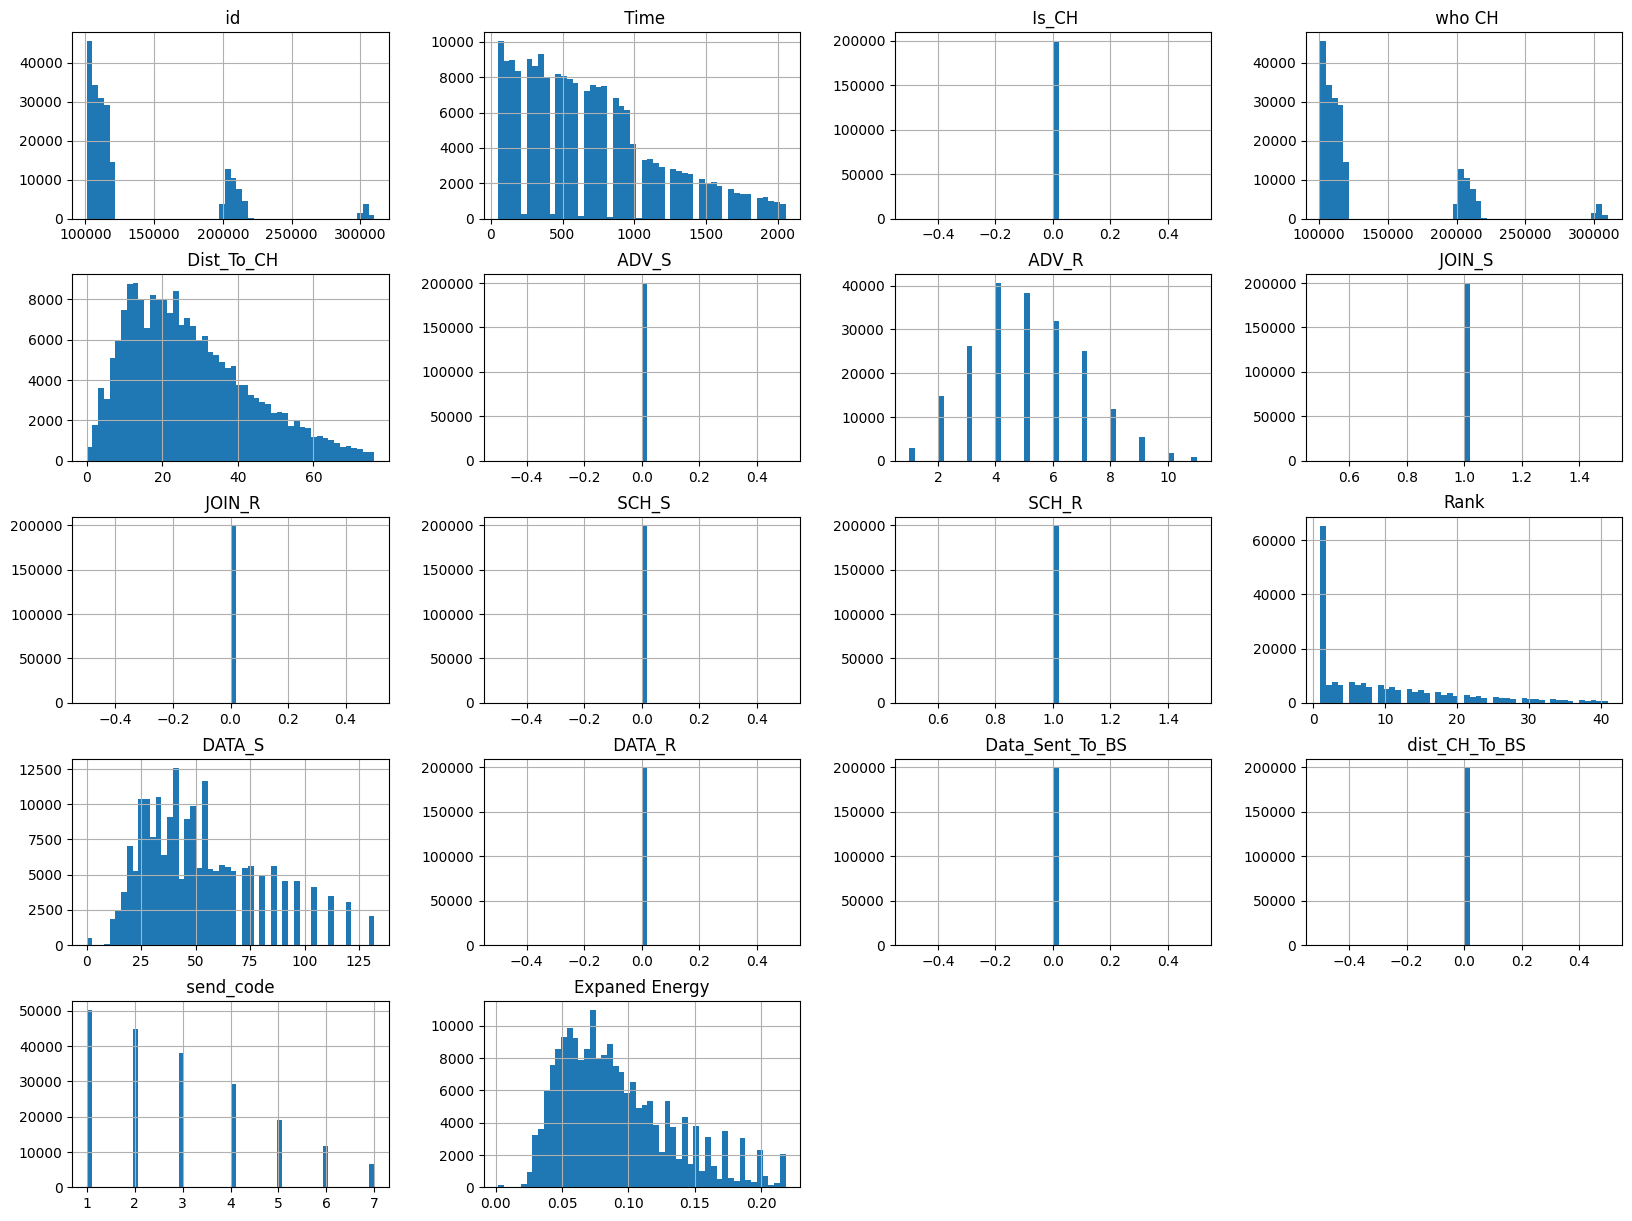

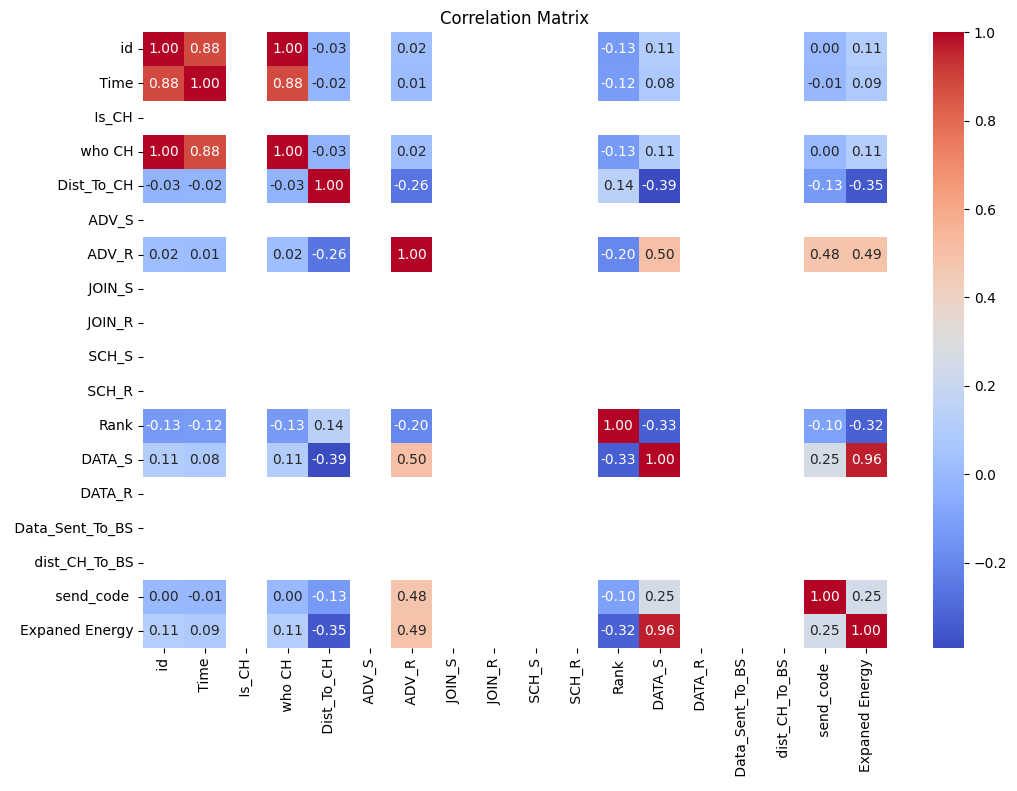

In [13]:
# Visualize the distribution of features
data.hist(bins=50, figsize=(20, 15))
plt.show()

# Filter numeric columns for correlation matrix
numeric_columns = data.select_dtypes(include=[np.number]).columns
corr_matrix = data[numeric_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

2.2 Identify Patterns or Trends

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

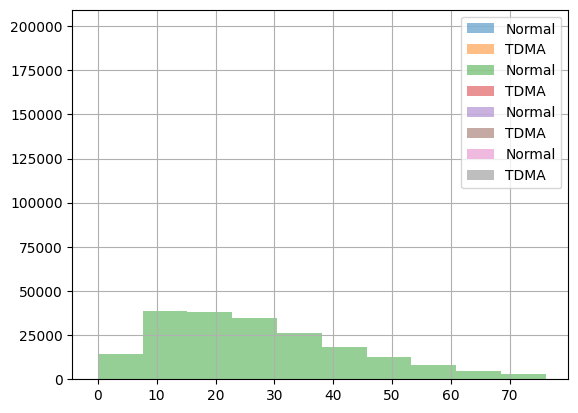

In [15]:
for feature in ['Expaned Energy', ' Dist_To_CH', ' ADV_S', ' DATA_R']:  # Add relevant features
    data.groupby('Attack type')[feature].hist(alpha=0.5, legend=True)

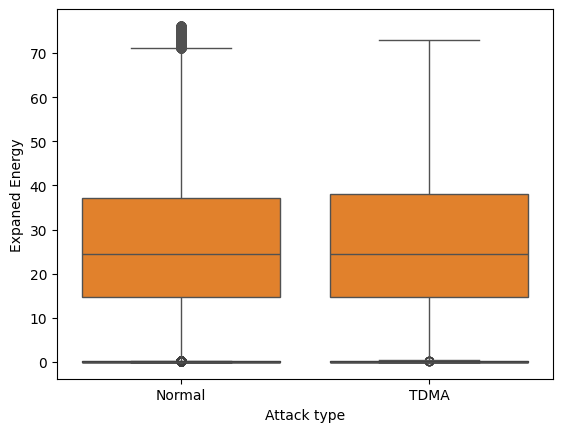

In [16]:
for feature in ['Expaned Energy', ' Dist_To_CH', ' ADV_S', ' DATA_R']:  # Change misspelled feature names
    sns.boxplot(x='Attack type', y=feature, data=data)

2.4 Use appropriate colors, markers, and styling to differentiate between different classes in the dataset during visualization.

In [18]:
import matplotlib.pyplot as plt

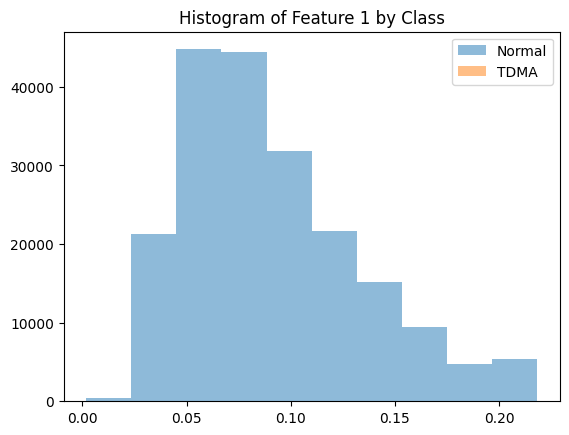

In [17]:
for attack_type in data['Attack type'].unique():
    subset = data[data['Attack type'] == attack_type]
    plt.hist(subset['Expaned Energy'], alpha=0.5, label=attack_type)
    plt.legend()
plt.title('Histogram of Feature 1 by Class')
plt.show()

Step 3: Feature Engineering

3.1 Extract relevant features from the dataset.

In [19]:
relevant_features = [' Time', ' Dist_To_CH', ' ADV_S', ' DATA_R']

data_subset = data[relevant_features]

# Print the first five rows of the data subset
print(data_subset.head())

    Time   Dist_To_CH   ADV_S   DATA_R
1     50     75.32345       0        0
2     50     46.95453       0        0
3     50     64.85231       0        0
4     50      4.83341       0        0
5     50     31.91198       0        0


3.2 Perform dimensionality reduction techniques if needed to reduce computational complexity.

In [20]:
from sklearn.decomposition import PCA

# Create a PCA instance with 2 components
pca = PCA(n_components=2)

# Fit the PCA instance to the data
pca.fit(data_subset)

# Transform the data using the fitted PCA instance
data_reduced = pca.transform(data_subset)

# Print the shape of the reduced data
print(data_reduced.shape)

(199629, 2)


3.3 Prepare the dataset for model training by encoding categorical variables and scaling numerical features.

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Define relevant features
relevant_features = [' Time', ' Dist_To_CH', ' ADV_S', ' DATA_R', 'Attack type']

# Create a subset of data with relevant features
data_subset = data[relevant_features]

# Encode categorical variables
label_encoder = LabelEncoder()
data_subset['Attack type'] = label_encoder.fit_transform(data_subset['Attack type'])

# Scale numerical features
scaler = StandardScaler()
data_subset[[' Time', ' Dist_To_CH', ' ADV_S', ' DATA_R']] = scaler.fit_transform(data_subset[[' Time', ' Dist_To_CH', ' ADV_S', ' DATA_R']])

# Print the first five rows of the preprocessed data
print(data_subset.head())

       Time   Dist_To_CH   ADV_S   DATA_R  Attack type
1 -1.331076     3.010671     0.0      0.0            0
2 -1.331076     1.231118     0.0      0.0            0
3 -1.331076     2.353827     0.0      0.0            0
4 -1.331076    -1.411098     0.0      0.0            0
5 -1.331076     0.287514     0.0      0.0            0


<ipython-input-21-aa451fca6f0c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['Attack type'] = label_encoder.fit_transform(data_subset['Attack type'])
<ipython-input-21-aa451fca6f0c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset[[' Time', ' Dist_To_CH', ' ADV_S', ' DATA_R']] = scaler.fit_transform(data_subset[[' Time', ' Dist_To_CH', ' ADV_S', ' DATA_R']])


Step 4: Model Selection and Building

4.1Split the preprocessed dataset into training and testing sets to enable model evaluation.

In [22]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_subset.drop('Attack type', axis=1),  # Features
    data_subset['Attack type'],  # Target variable
    test_size=0.2,  # 20% of the data will be used for testing
    random_state=42  # Random seed for reproducibility
)

# Print the shapes of the training and testing sets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (159703, 4)
Shape of X_test: (39926, 4)
Shape of y_train: (159703,)
Shape of y_test: (39926,)


4.2 Choose at least five classification algorithms (e.g., Naïve Bayes, Decision Trees, Support Vector Machine, KNN, Random Forest) for comparison.

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Define a dictionary to store the classifiers
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
}

# Train each classifier on the training data
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    print(f"{name} trained successfully.")

Naive Bayes trained successfully.
Decision Tree trained successfully.
Support Vector Machine trained successfully.
KNN trained successfully.
Random Forest trained successfully.


4.3 Implement each chosen algorithm using appropriate libraries in Python, and train the models using the training dataset.

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Print column names to identify the target column
print(data.columns)

# Assuming 'label' is the correct column name for class labels, replace 'label' with the actual name
class_column = 'Attack type'  # Change this to the actual column name

# Separate features (X) and target labels (y)
X = data.drop(columns=[class_column])
y = data[class_column]
# Check for and print any potential issues with the target variable
print(f"Type of y: {type(y)}")
print(f"Shape of y: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of y_train
print(f"Type of y_train: {type(y_train)}")
print(f"Shape of y_train: {y_train.shape}")

# Reshape y_train if needed
if y_train.ndim != 1:
    y_train = y_train.reshape(-1,)

# Define the classifiers
gnb = GaussianNB()
dtree = DecisionTreeClassifier()
svm = SVC()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

# Train each classifier
classifiers = [gnb, dtree, svm, knn, rf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    print(f"{classifier.__class__.__name__} trained successfully.")

Index([' id', ' Time', ' Is_CH', ' who CH', ' Dist_To_CH', ' ADV_S', ' ADV_R',
       ' JOIN_S', ' JOIN_R', ' SCH_S', ' SCH_R', 'Rank', ' DATA_S', ' DATA_R',
       ' Data_Sent_To_BS', ' dist_CH_To_BS', ' send_code ', 'Expaned Energy',
       'Attack type'],
      dtype='object')
Type of y: <class 'pandas.core.series.Series'>
Shape of y: (199629,)
Type of y_train: <class 'pandas.core.series.Series'>
Shape of y_train: (159703,)
GaussianNB trained successfully.
DecisionTreeClassifier trained successfully.
SVC trained successfully.
KNeighborsClassifier trained successfully.
RandomForestClassifier trained successfully.


4.4 Optimize hyperparameters for each model to improve classification performance, using techniques such as grid search or random search.

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Print column names to identify the target column
print(data.columns)

# Assuming 'label' is the correct column name for class labels, replace 'label' with the actual name
class_column = 'Attack type'  # Change this to the actual column name

# Separate features (X) and target labels (y)
X = data.drop(columns=[class_column])
y = data[class_column]

# Check for and print any potential issues with the target variable
print(f"Type of y: {type(y)}")
print(f"Shape of y: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of y_train
print(f"Type of y_train: {type(y_train)}")
print(f"Shape of y_train: {y_train.shape}")

# Reshape y_train if needed
if y_train.ndim != 1:
    y_train = y_train.reshape(-1,)

# Define the classifiers
gnb = GaussianNB()
dtree = DecisionTreeClassifier()
svm = SVC()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

classifiers = [gnb, dtree, svm, knn, rf]
# Train each classifier
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    print(f"{classifier.__class__.__name__} trained successfully.")

# Define parameters for each model
param_grid = {
    "Naive Bayes": {"var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]},
    "Decision Tree": {"criterion": ["gini", "entropy"], "max_depth": [5, 10, 15]}
}

Index([' id', ' Time', ' Is_CH', ' who CH', ' Dist_To_CH', ' ADV_S', ' ADV_R',
       ' JOIN_S', ' JOIN_R', ' SCH_S', ' SCH_R', 'Rank', ' DATA_S', ' DATA_R',
       ' Data_Sent_To_BS', ' dist_CH_To_BS', ' send_code ', 'Expaned Energy',
       'Attack type'],
      dtype='object')
Type of y: <class 'pandas.core.series.Series'>
Shape of y: (199629,)
Type of y_train: <class 'pandas.core.series.Series'>
Shape of y_train: (159703,)
GaussianNB trained successfully.
DecisionTreeClassifier trained successfully.
SVC trained successfully.
KNeighborsClassifier trained successfully.
RandomForestClassifier trained successfully.


Step 5: Ensemble Model Building

5.1 Choose a suitable ensemble method (Bagging, Boosting, or Stacking). 5.2 Implement the ensemble model using appropriate libraries in Python, and train it using the training dataset.

In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier  # Example base estimator

# Initialize the BaggingClassifier with a DecisionTreeClassifier as the base
bagging_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    n_estimators=10,
    random_state=42
)

# Train the BaggingClassifier
bagging_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

5.3 Tune the hyperparameters of the ensemble model to optimize its performance.

In [27]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 55.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize standalone classifiers
nb = GaussianNB()
dt = DecisionTreeClassifier()
svm = SVC()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

# **This part needs to be fixed. You need to define what 'best_model' is**
# For example, if you determined that RandomForest was the best model:
best_model = RandomForestClassifier()
# Fit the best model to your training data if it hasn't been done already
best_model.fit(X_train, y_train)

# List of classifiers and their names
classifiers = [nb, dt, svm, knn, rf, best_model]
names = ["Naive Bayes", "Decision Tree", "SVM", "KNN", "Random Forest", "Ensemble"]

# Evaluate each classifier
for clf, name in zip(classifiers, names):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted')}")
    print("-" * 30)

Classifier: Naive Bayes
Accuracy: 0.9986224515353403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`


Precision: 0.9972468007104534
Recall: 0.9986224515353403
F1-Score: 0.9979341520399403
------------------------------
Classifier: Decision Tree
Accuracy: 0.9968692080348645
Precision: 0.9973315938985389
Recall: 0.9968692080348645
F1-Score: 0.9970993971605353
------------------------------
Classifier: SVM
Accuracy: 0.9986224515353403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`


Precision: 0.9972468007104534
Recall: 0.9986224515353403
F1-Score: 0.9979341520399403
------------------------------
Classifier: KNN
Accuracy: 0.9986224515353403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`


Precision: 0.9972468007104534
Recall: 0.9986224515353403
F1-Score: 0.9979341520399403
------------------------------
Classifier: Random Forest
Accuracy: 0.9985974051996193
Precision: 0.9972467662545778
Recall: 0.9985974051996193
F1-Score: 0.9979216287210892
------------------------------
Classifier: Ensemble
Accuracy: 0.9985974051996193
Precision: 0.9972467662545778
Recall: 0.9985974051996193
F1-Score: 0.9979216287210892
------------------------------


Step 6: Model Evaluation

6.1 Evaluate the performance of each model using the testing dataset.
6.2 Generate a classification report for each model, including metrics such as precision, recall, F1-score, and accuracy for each class.

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Initialize standalone classifiers
nb = GaussianNB()
dt = DecisionTreeClassifier()
svm = SVC()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()

# Assuming you have determined that RandomForest is the best model:
best_model = RandomForestClassifier()
best_model.fit(X_train, y_train)  # Fit the best model if not done previously

# List of classifiers and their names
classifiers = [nb, dt, svm, knn, rf, best_model]
names = ["Naive Bayes", "Decision Tree", "SVM", "KNN", "Random Forest", "Best Model (Ensemble)"]

# Evaluate each classifier on the testing dataset
for clf, name in zip(classifiers, names):
    clf.fit(X_train, y_train)  # Fit the classifier to the training data
    y_pred = clf.predict(X_test)  # Make predictions on the testing data

    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted')}")
    print(classification_report(y_test, y_pred))  # Generate classification report
    print("-" * 30)

Classifier: Naive Bayes
Accuracy: 0.9986224515353403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`


Precision: 0.9972468007104534
Recall: 0.9986224515353403
F1-Score: 0.9979341520399403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :t

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     39871
        TDMA       0.00      0.00      0.00        55

    accuracy                           1.00     39926
   macro avg       0.50      0.50      0.50     39926
weighted avg       1.00      1.00      1.00     39926

------------------------------
Classifier: Decision Tree
Accuracy: 0.9965936983419326
Precision: 0.9972440041809811
Recall: 0.9965936983419326
F1-Score: 0.9969187452102763
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     39871
        TDMA       0.00      0.00      0.00        55

    accuracy                           1.00     39926
   macro avg       0.50      0.50      0.50     39926
weighted avg       1.00      1.00      1.00     39926

------------------------------
Classifier: SVM
Accuracy: 0.9986224515353403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`


Precision: 0.9972468007104534
Recall: 0.9986224515353403
F1-Score: 0.9979341520399403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :t

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     39871
        TDMA       0.00      0.00      0.00        55

    accuracy                           1.00     39926
   macro avg       0.50      0.50      0.50     39926
weighted avg       1.00      1.00      1.00     39926

------------------------------
Classifier: KNN
Accuracy: 0.9986224515353403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`


Precision: 0.9972468007104534
Recall: 0.9986224515353403
F1-Score: 0.9979341520399403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :t

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     39871
        TDMA       0.00      0.00      0.00        55

    accuracy                           1.00     39926
   macro avg       0.50      0.50      0.50     39926
weighted avg       1.00      1.00      1.00     39926

------------------------------
Classifier: Random Forest
Accuracy: 0.9985974051996193
Precision: 0.9972467662545778
Recall: 0.9985974051996193
F1-Score: 0.9979216287210892
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     39871
        TDMA       0.00      0.00      0.00        55

    accuracy                           1.00     39926
   macro avg       0.50      0.50      0.50     39926
weighted avg       1.00      1.00      1.00     39926

------------------------------
Classifier: Best Model (Ensemble)
Accuracy: 0.9985974051996193
Precision: 0.9972467662545778
Recall: 0.9985974051996193
F1-Score: 0.99792162872

6.3Find AUC-ROC curve

In [30]:
!pip install scikit-learn
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np # Assuming you need numpy for unique classes

In [31]:
# Assuming X_train, y_train, X_test, y_test are already defined

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [32]:
# Assuming 'y' is your true labels and 'scores' are the predicted probabilities
y = label_binarize(y_test, classes=np.unique(y_test)) # Binarize labels for multi-class ROC
n_classes = y.shape[1]

In [33]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = roc_auc_score(y[:, i], best_model.predict_proba(X_test)[:, i])


In [34]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = roc_auc_score(y[:, i], best_model.predict_proba(X_test)[:, i])


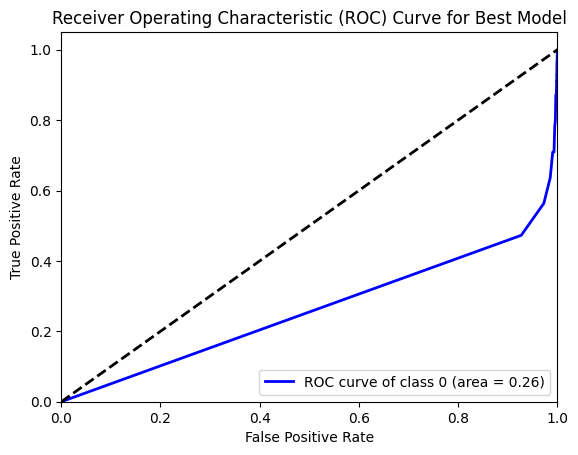

In [35]:
# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'yellow', 'black']) # Adjust colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Best Model')
plt.legend(loc="lower right")
plt.show()

In [36]:
# After calculating ROC curves and AUC for each class
for i in range(n_classes):
    print(f"AUC for class {i}: {roc_auc[i]}")

AUC for class 0: 0.26129312487317047


6.4 Plot confusion matrices to visualize the true positive, false positive, true negative, and false negative predictions of each model.

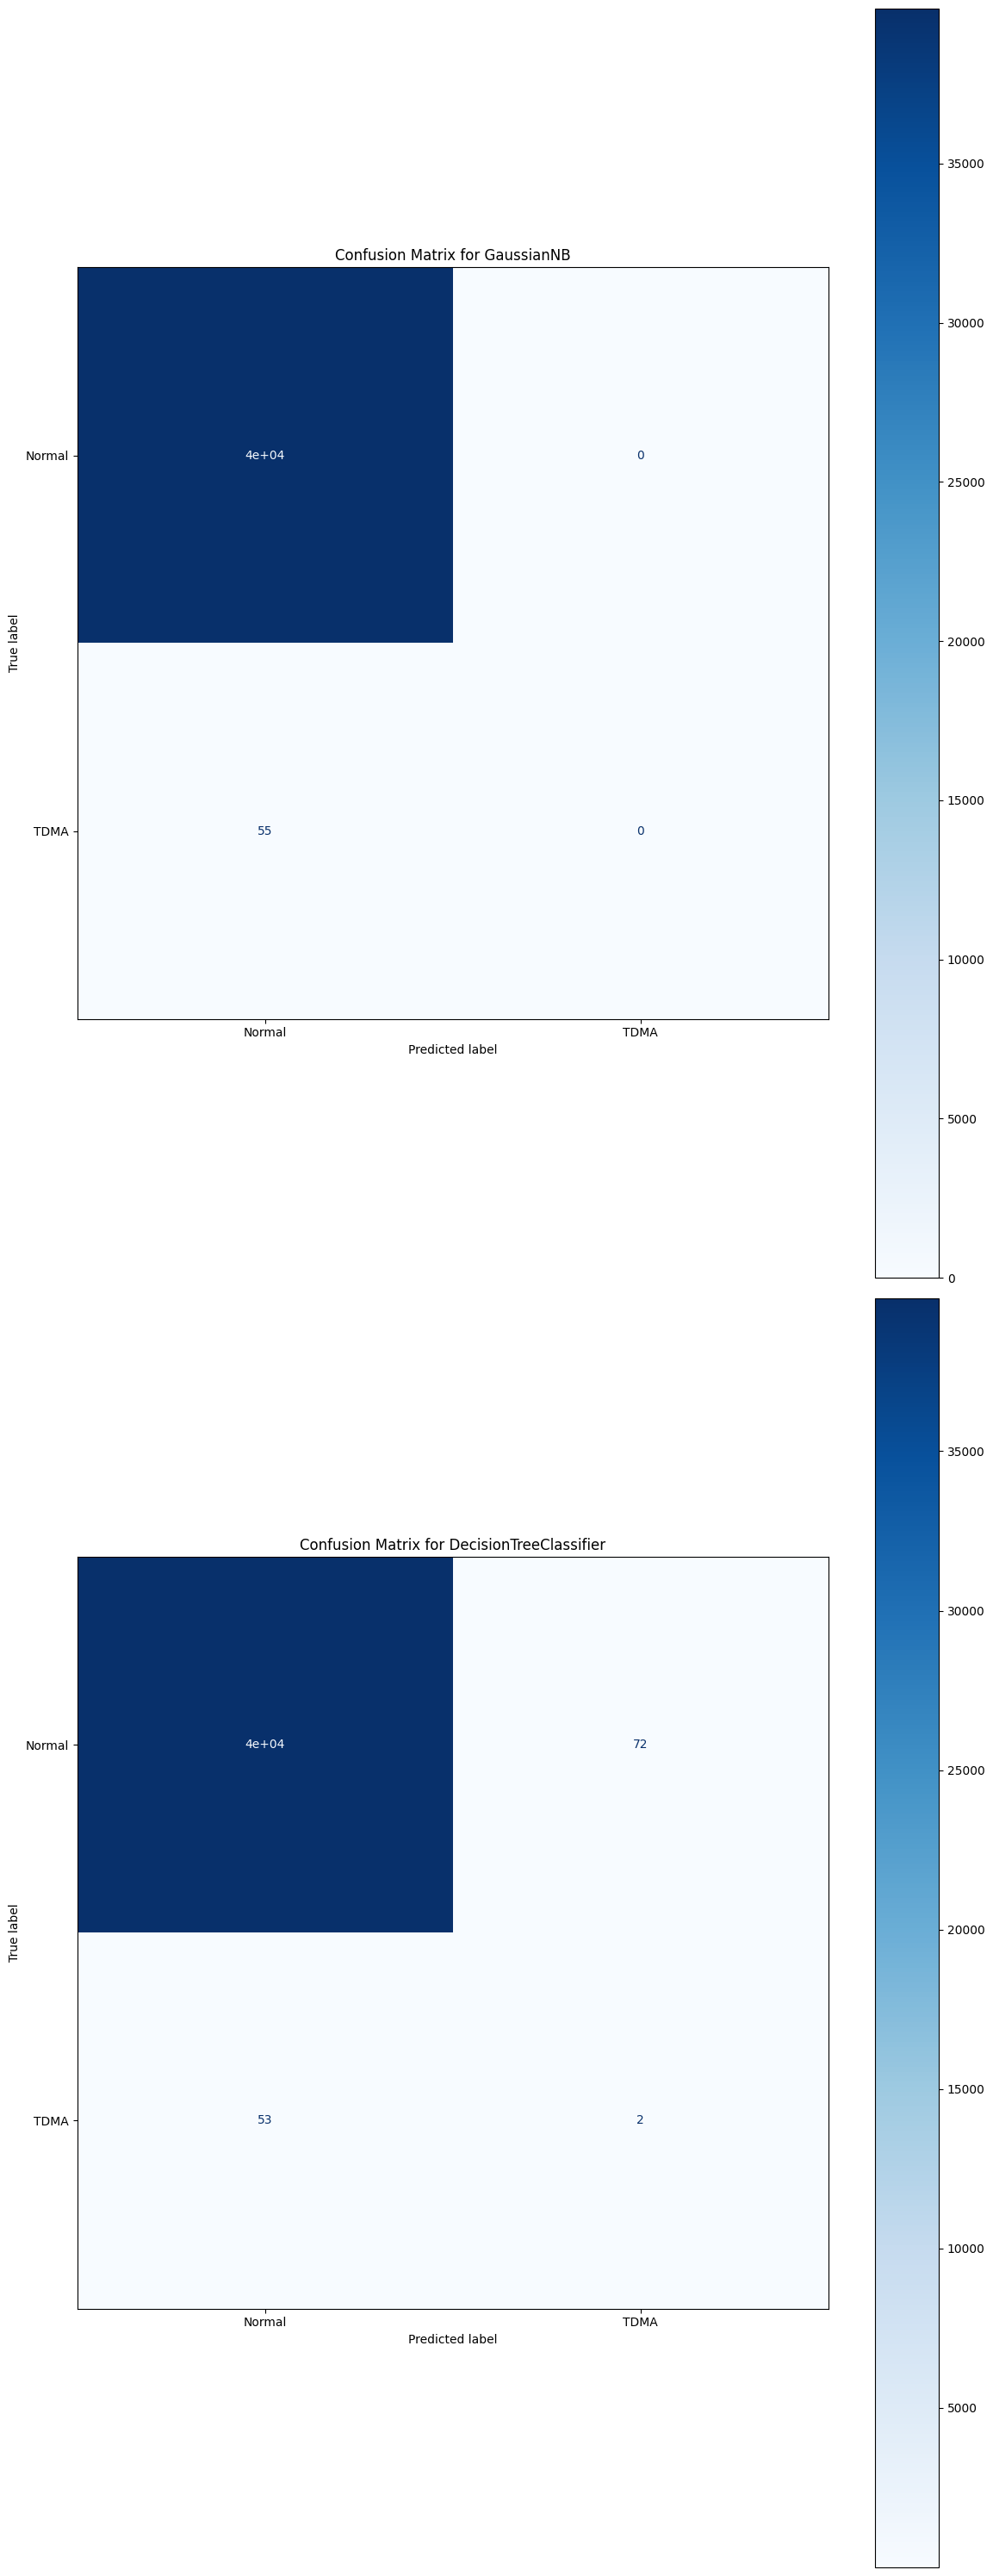

In [42]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

# Assuming 'classifiers' was intended to be a dictionary
# If it was a list, you'll need to adjust how you access names and classifiers
classifiers = { # Example, replace with your actual classifier names and instances
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    # ... add other classifiers
}

# Fit the classifiers before predicting
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Assuming you have X_train and y_train defined

# Initialize LabelEncoder
le = LabelEncoder()
# Fit label encoder and transform y_test (assuming y_test is your true labels for the test set)
y_test_encoded = le.fit_transform(y_test)

# Plot confusion matrices
fig, axes = plt.subplots(len(classifiers), 1, figsize=(12, 30))

for ax, (name, clf) in zip(axes, classifiers.items()):
    y_pred = clf.predict(X_test)
    # Encode predictions to match the encoded true labels
    y_pred_encoded = le.transform(y_pred)
    cm = confusion_matrix(y_test_encoded, y_pred_encoded) # Use encoded labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=ax, cmap='Blues')
    ax.title.set_text(f'Confusion Matrix for {name}')

plt.tight_layout()
plt.show()

6.5 Analyze the classification reports and confusion matrices to compare the performance of different algorithms and identify strengths and weaknesses.

Classifier: GaussianNB
Accuracy: 0.9986224515353403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`


Precision: 0.9972468007104534
Recall: 0.9986224515353403
F1-Score: 0.9979341520399403


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :term:`multiclass`
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Support beyond term:`binary` targets is achieved by treating :t

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     39871
        TDMA       0.00      0.00      0.00        55

    accuracy                           1.00     39926
   macro avg       0.50      0.50      0.50     39926
weighted avg       1.00      1.00      1.00     39926



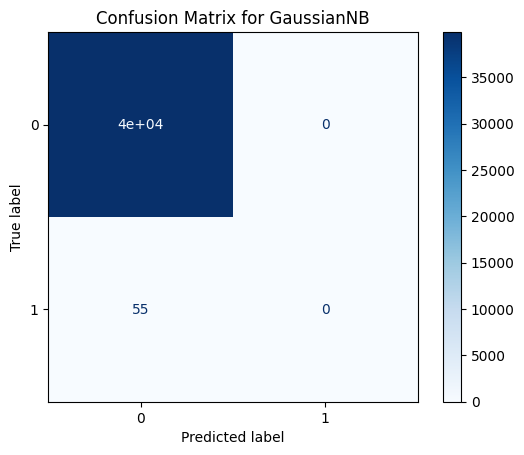

------------------------------
Classifier: DecisionTreeClassifier
Accuracy: 0.9968692080348645
Precision: 0.9973315938985389
Recall: 0.9968692080348645
F1-Score: 0.9970993971605353
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     39871
        TDMA       0.03      0.04      0.03        55

    accuracy                           1.00     39926
   macro avg       0.51      0.52      0.51     39926
weighted avg       1.00      1.00      1.00     39926



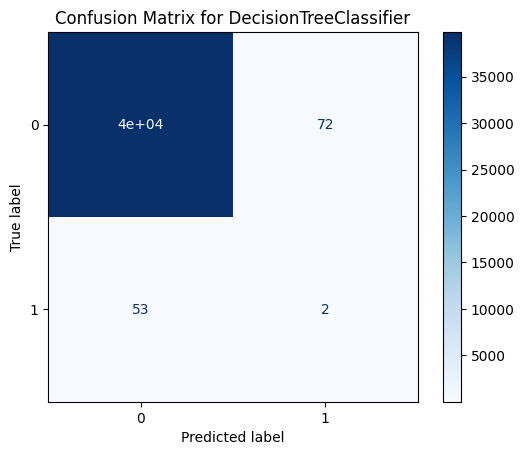

------------------------------


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have your classifiers in a dictionary called 'classifiers'
# And you have your test data X_test and y_test

for name, clf in classifiers.items():
    # Fit the classifier if it's not already fitted
    if not hasattr(clf, "classes_"):  # Check if the classifier is fitted
        clf.fit(X_train, y_train)  # Replace X_train and y_train with your training data

    Y_Pred = clf.predict(X_test)

    # Removed the extra indent here
    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy_score(y_test, Y_Pred)}") # Use Y_Pred (predicted values)
    print(f"Precision: {precision_score(y_test, Y_Pred, average='weighted')}") # Use Y_Pred
    print(f"Recall: {recall_score(y_test, Y_Pred, average='weighted')}") # Use Y_Pred
    print(f"F1-Score: {f1_score(y_test, Y_Pred, average='weighted')}") # Use Y_Pred
    print(classification_report(y_test, Y_Pred))  # Generate classification report

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, Y_Pred) # Use Y_Pred
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    print("-" * 30)